In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "4"

import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import corner
import batman
import emcee
import time
from multiprocessing import Pool
from IPython.display import display, Math
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as tck

from exotic_ld import StellarLimbDarkening

import pandas as pd
import pickle

import celerite2
from celerite2 import terms


In [2]:
TIC = 'TIC 66818296' #WASP-17 / TIC 66818296

search_result = lk.search_lightcurve(
    target=TIC,
    mission='TESS', author='SPOC')
print("trying to download")
lc_collection = search_result.download_all()
print("Search done")
print(lc_collection)

lc = lc_collection.stitch(corrector_func=lambda x: x.
                          remove_nans().normalize(unit='unscaled'))
#Sector 12 and sector 38
lc = lc.remove_nans()

trying to download
Search done
LightCurveCollection of 2 objects:
    0: <TessLightCurve LABEL="TIC 66818296" SECTOR=12 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 66818296" SECTOR=38 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>


In [3]:
lc

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,,,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1628.9527366213874,9.9146342e-01,2.2294226e-03,5.7549695e-03,289074,1734.75869,254.41609,5.6552012e+03,1.2536695e+01,4.5658228e+03,5.9796586e+00,6.3341509e+03,1.4243086e+01,0,———,———,———,———,1734.75869,1.7931858e-03,254.41609,1.7716236e-03,4.0939126e-02,2.0365320e-01
1628.9541255101508,9.9583793e-01,2.2304894e-03,5.7549700e-03,289075,1734.74578,254.42646,5.6748306e+03,1.2542694e+01,4.5680073e+03,5.9771156e+00,6.3620981e+03,1.4249902e+01,0,———,———,———,———,1734.74578,1.7894373e-03,254.42646,1.7657484e-03,2.5400141e-02,2.1769401e-01
1628.955514398915,9.9091458e-01,2.2287809e-03,5.7549705e-03,289076,1734.75697,254.42326,5.6416396e+03,1.2533087e+01,4.5655005e+03,5.9784079e+00,6.3306445e+03,1.4238987e+01,0,———,———,———,———,1734.75697,1.8040523e-03,254.42326,1.7733830e-03,3.9708838e-02,2.1558438e-01
1628.9569032876798,9.9025726e-01,2.2276556e-03,5.7549709e-03,289077,1734.77388,254.40724,5.6449824e+03,1.2526758e+01,4.5653208e+03,5.9806061e+00,6.3264453e+03,1.4231798e+01,0,———,———,———,———,1734.77388,1.8003181e-03,254.40724,1.7727494e-03,5.3074531e-02,1.9718842e-01
1628.9582921764436,9.9405742e-01,2.2288344e-03,5.7549714e-03,289078,1734.75465,254.41574,5.6675269e+03,1.2533387e+01,4.5580649e+03,5.9763598e+00,6.3507231e+03,1.4239328e+01,0,———,———,———,———,1734.75465,1.7944344e-03,254.41574,1.7658967e-03,4.2726278e-02,2.0543911e-01
1628.959681065207,9.9572426e-01,2.2284959e-03,5.7549719e-03,289079,1734.73932,254.42526,5.6712891e+03,1.2531484e+01,4.5560479e+03,5.9750943e+00,6.3613721e+03,1.4237165e+01,0,———,———,———,———,1734.73932,1.7894540e-03,254.42526,1.7633970e-03,2.1659279e-02,2.1886539e-01
1628.961069953971,9.9142510e-01,2.2267138e-03,5.7549723e-03,289080,1734.75758,254.41773,5.6525649e+03,1.2521463e+01,4.5581753e+03,5.9713359e+00,6.3339062e+03,1.4225781e+01,0,———,———,———,———,1734.75758,1.7970275e-03,254.41773,1.7686322e-03,3.9847802e-02,2.0756216e-01
1628.962458842735,9.9342662e-01,2.2281376e-03,5.7549728e-03,289081,1734.75298,254.41704,5.6614937e+03,1.2529469e+01,4.5481836e+03,5.9697313e+00,6.3466934e+03,1.4234877e+01,0,———,———,———,———,1734.75298,1.7935706e-03,254.41704,1.7688903e-03,3.7096344e-02,2.0781381e-01


In [4]:
t = np.array(lc.time.btjd)
flux_data = np.array(lc.flux)
yerrs = np.array(lc.flux_err)

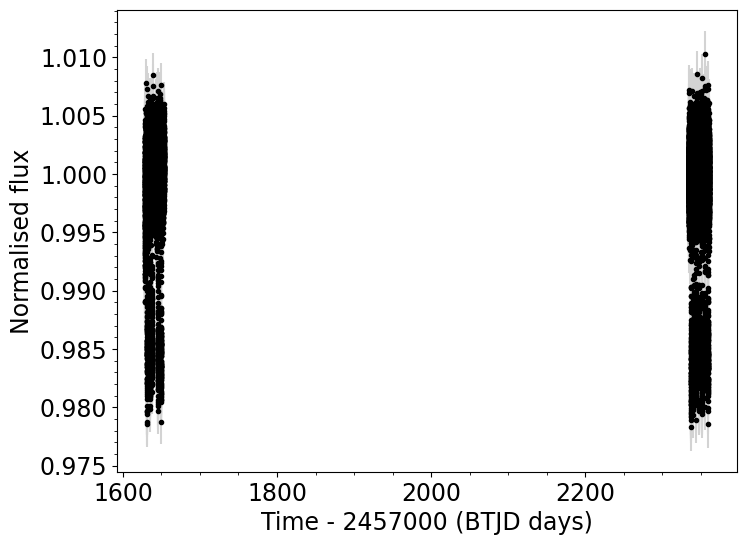

In [5]:
fig, ax = plt.subplots(1, figsize=(8,6))
plt.errorbar(t, flux_data, yerrs, fmt='.', color='Black', ecolor='LightGrey')


plt.ylabel("Normalised flux", size=17)
plt.xlabel("Time - 2457000 (BTJD days)", size=17)

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)

ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())

plt.show()


In [6]:
def set_params(params, yerrs):
    _sigma, _rho = params
    kernel = terms.Matern32Term(sigma = _sigma, rho  = _rho)
    gp = celerite2.GaussianProcess(kernel, mean=0.0,)
    gp.compute(t, yerr=yerrs, quiet=True)

    return gp

In [7]:
def log_likelihood(prior_params, flux_data, yerrs):
    
    gp = set_params(prior_params, yerrs)

    prob = gp.log_likelihood(flux_data)
    return prob


def log_prior(prior_params):
    _sigma, _rho = prior_params

    prob = 0.0
    if _sigma < 0 or _sigma > 5E4:
        prob += -np.inf
        return prob
    
    if _rho < 0 or _rho > 5E4:
        prob += -np.inf
        return prob
    
    return prob


def log_prob(prior_params, flux_data, yerrs):
    lp = log_prior(prior_params)
    if (np.isinf(lp) == True):
        return -np.inf

    return log_likelihood(prior_params, flux_data, yerrs) + lp

In [8]:
guess = [2, 2] #Sigma, rho

pos = guess + 1E-8 * np.random.randn(20, len(guess))

nwalkers, ndim = pos.shape

filename = "matern32_tess_data.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

with Pool() as pool:
    start_time = time.time()
    print("Start:       {}".format(time.ctime(int(start_time))))
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(flux_data, yerrs))
    sampler.run_mcmc(pos, 20000, progress=True)
    
    end_time = time.time()
    execution_time = (end_time - start_time)
    print("End:         {}".format(time.ctime(int(end_time))))
    print("Time taken:  {:.2f} s".format(execution_time))

Start:       Thu Feb  9 13:32:12 2023


100%|██████████| 20000/20000 [35:39<00:00,  9.35it/s]

End:         Thu Feb  9 14:07:52 2023
Time taken:  2139.25 s


In [9]:
samples = sampler.get_chain()
tau = sampler.get_autocorr_time()
print(tau)

[46.80043025 45.38277484]


In [10]:
burnin = int(5 * np.max(tau))
thin = int(0.5 * np.min(tau))
flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
print(flat_samples.shape)

(17960, 2)


In [11]:
filename = "matern32_tess_flat_samples.p"
file = open(filename, "wb")
pickle.dump(samples, file)
file.close()

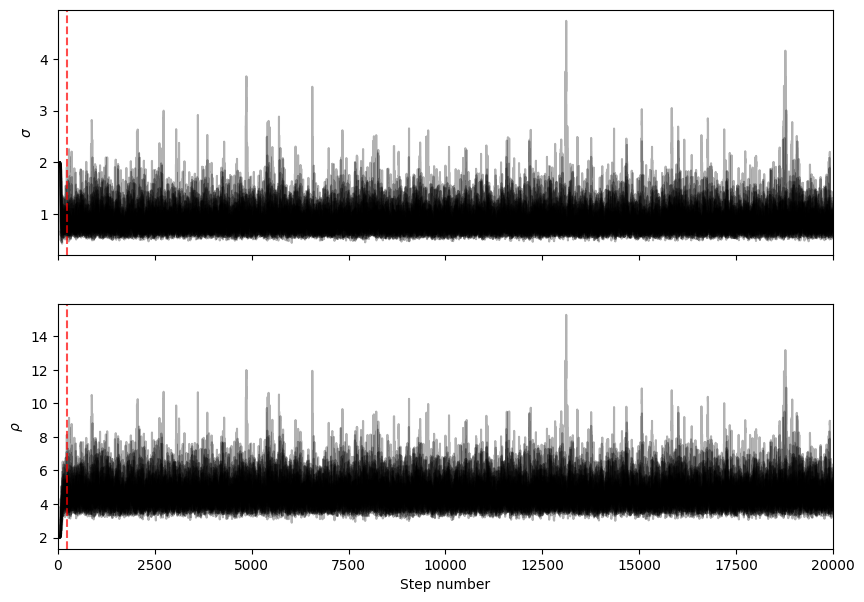

In [12]:
fig, axes = plt.subplots(len(guess), figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$\\sigma$", "$\\rho$"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.axvline(x = burnin, color ='red', ls="--", alpha=0.7)
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("Step number")
plt.show()

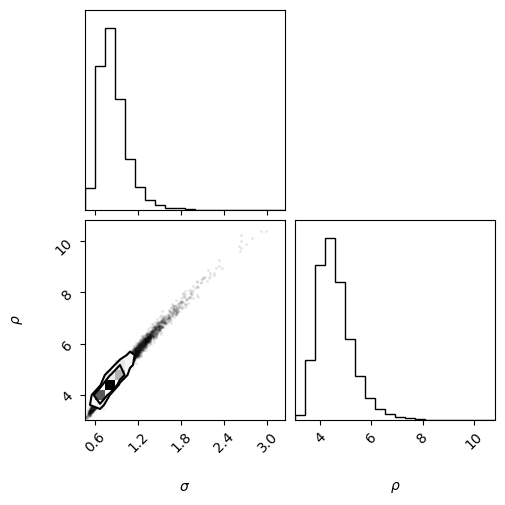

In [13]:
fig = corner.corner(
    flat_samples, labels=labels)
